# Logistic Regression
We will build a logistic regression classifier.

We will classify pictures with and without cats.


## 0 - Donwload data

In [ ]:
!pip install wget
import wget
wget.download('https://dru.fra1.digitaloceanspaces.com/DS_Fundamentals/datasets/04_supervised_learning/Logistic_Regression/test_cats.h5')
wget.download('https://dru.fra1.digitaloceanspaces.com/DS_Fundamentals/datasets/04_supervised_learning/Logistic_Regression/train_cats.h5')

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b8a0ea77d0adbfff1b83658b194a7670dba3c075a9a0d024119a583a6a48cae6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


'train_cats.h5'

## 1 - Packages ##

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline

## 2 - Overview of the Problem set ##

* a training set of `m_train` examples labeled as (y=1) or (y=0)
* a test set of `m_test` examples as (y=1) or (y=0)
* each example is of shape (number of features = 64 * 64 * 3, 1)

In [ ]:
# Loading the data

def load_data():
    train_dataset = h5py.File("train_cats.h5", "r")
    train_set_x = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File("test_cats.h5", "r")
    test_set_x = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes

    # Images have (64(width), 64(height), 3(RGB)) dimensions, we need to have all the pixels as features
    test_set_x = test_set_x.reshape(test_set_x.shape[0], -1).T # shape ((209)examples, (64)width, (64)height, (3)RGB) -> (64 * 64 * 3, 209)
    train_set_x = train_set_x.reshape(train_set_x.shape[0], -1).T # shape ((209)examples, (64)width, (64)height, (3)RGB) -> (64 * 64 * 3, 209)

    train_set_y = train_set_y.reshape((1, train_set_y.shape[0]))
    test_set_y = test_set_y.reshape((1, test_set_y.shape[0]))

    return train_set_x, train_set_y, test_set_x, test_set_y, classes

train_set_x, train_set_y, test_set_x, test_set_y, classes = load_data()

In [ ]:
print (train_set_x.shape, train_set_y.shape, test_set_x.shape, test_set_y.shape, classes.shape)

(12288, 209) (1, 209) (12288, 50) (1, 50) (2,)


### Example of a picture

y = [1], it's a 'cat' picture.


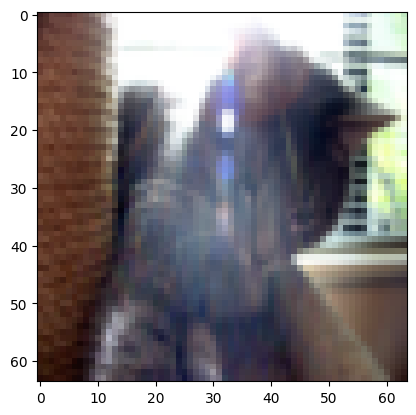

In [ ]:
index = 42
plt.imshow(train_set_x[:,index].reshape((64, 64, 3)))
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [ ]:
m_train = train_set_x.shape[1]
m_test = test_set_x.shape[1]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))

print ("\ntrain_set_x shape: " + str(train_set_x.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50

train_set_x shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x shape: (12288, 50)
test_set_y shape: (1, 50)


### "Standardization"

In [ ]:
train_set_x = train_set_x / 255.
test_set_x = test_set_x / 255.

Common steps for pre-processing a new dataset are:
- Figure out the dimensions and shapes of the problem (m_train, m_test, ...)
- Reshape the datasets such that each example is now a vector of size (number of features, 1)
- "Standardize" the data

## 3 - General Architecture of the learning algorithm ##

**Mathematical expression of the algorithm**:

For one example $x^{(i)}$:

Compute Linear Regression: $z^{(i)} = w^T x^{(i)} + b \tag{1}$
Pass it through the activation function: $\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$
We will use log-loss as a loss function:

$$\mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

The cost is then computed by summing over all training examples:
$$ J(w, b) = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{4}$$


## 4 - Building the parts of our algorithm ##

The main steps for building a learning algorithm:
1. Define the model structure (such as number of input features)
2. Initialize the model's parameters
3. Loop:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)

### 4.1 - Helper functions


In [ ]:
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """

    s = 1/(1 + np.exp(-z))

    return s

In [ ]:
print ("sigmoid([0, 2]) = " + str(sigmoid(np.array([0,2]))))

sigmoid([0, 2]) = [0.5        0.88079708]


### 4.2 - Initializing parameters

In [ ]:
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.

    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)

    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """

    w = np.zeros((dim, 1))
    b = 0

    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))

    return w, b

In [ ]:
dim = 2
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]]
b = 0


### 4.3 - Forward and Backward propagation

Forward Propagation:
- You get X
- You compute $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
- You calculate the cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)})$

Here are the two formulas
$$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{5}$$
$$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{6}$$

In [ ]:
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (number of features, 1)
    b -- bias, a scalar
    X -- data of size (number of features, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b


    """

    m = X.shape[1]

    # FORWARD PROPAGATION (FROM X TO COST)

    A = sigmoid(np.dot(w.T, X) + b)    # compute activation
    cost = -np.mean(Y * np.log(A) + (1-Y) * np.log(1-A)) # compute cost


    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = (1/m)*np.dot(X, (A-Y).T)
    db = np.mean(A-Y)

    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())

    grads = {"dw": dw,
             "db": db}

    return grads, cost

In [ ]:
w, b, X, Y = np.array([[1.],[2.]]), 2., np.array([[1.,2.,-1.],[3.,4.,-3.2]]), np.array([[1,0,1]])
grads, cost = propagate(w, b, X, Y)
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))
print ("cost = " + str(cost))

dw = [[0.99845601]
 [2.39507239]]
db = 0.001455578136784208
cost = 5.801545319394553


### 4.4 - Optimization

In [ ]:
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost=False):
    """
    This function optimizes w and b by running a gradient descent algorithm

    Arguments:
    w -- weights, a numpy array of size (number of features, 1)
    b -- bias, a scalar
    X -- data of shape (number of features, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps

    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.

    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """

    costs = []

    for i in range(num_iterations):


        # Cost and gradient calculation (≈ 1 line of code)
        grads, cost = propagate(w, b, X, Y)

        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]

        # update rule (≈ 2 lines of code)
        w -= learning_rate*dw
        b -= learning_rate*db

        # Record the costs
        if i % 100 == 0:
            costs.append(cost)

        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    params = {"w": w,
              "b": b}

    grads = {"dw": dw,
             "db": db}

    return params, grads, costs

In [ ]:
params, grads, costs = optimize(w, b, X, Y, num_iterations=100, learning_rate=0.009, print_cost=False)

print ("w = " + str(params["w"]))
print ("b = " + str(params["b"]))
print ("dw = " + str(grads["dw"]))
print ("db = " + str(grads["db"]))

w = [[0.19033591]
 [0.12259159]]
b = 1.9253598300845747
dw = [[0.67752042]
 [1.41625495]]
db = 0.21919450454067657


1. Calculate $\hat{Y} = A = \sigma(w^T X + b)$

2. Convert the entries of $A$ into 0 (if $\sigma(z)$ <= 0.5) or 1 (if $\sigma(z)$ > 0.5), stores the predictions in a vector `Y_prediction`. If you wish, you can use an `if`/`else` statement in a `for` loop (though there is also a way to vectorize this).

In [ ]:
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (number of features, 1)
    b -- bias, a scalar
    X -- data of size (number of features, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''

    m = X.shape[1]
    Y_prediction = np.zeros((1,m))

    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X) + b)

    # Convert probabilities A[0,i] to actual predictions p[0,i]
    Y_prediction = np.where(A > 0.5, 1, 0)
#     Y_prediction = (A > 0.5).astype(int)
    ### Variable with probabilities called Y_prediction


    assert(Y_prediction.shape == (1, m))
    return Y_prediction

In [ ]:
w = np.array([[0.1124579],[0.23106775]])
b = -0.3
X = np.array([[1.,-1.1,-3.2],[1.2,2.,0.1]])
print ("predictions = " + str(predict(w, b, X)))

predictions = [[1 1 0]]


**Expected Output**:

<table style="width:25%">
    <tr>
         <td>
             <b>predictions</b>
         </td>
          <td>
            [[ 1  1  0]]
         </td>  
   </tr>

</table>


<font color='green'>
    <b>What to remember:</b>
You've implemented several functions that:
    
* Initialize (w,b)
* Optimize the loss iteratively to learn parameters (w,b):
    * computing the cost and its gradient
    * updating the parameters using gradient descent
* Use the learned (w,b) to predict the labels for a given set of examples

## 5 - Merge all functions into a model ##

You will now see how the overall model is structured by putting together all the building blocks (functions implemented in the previous parts) together, in the right order.

**Exercise:** Implement the model function. Use the following notation:

* `Y_prediction_test` for your predictions on the test set
* `Y_prediction_train` for your predictions on the train set
* `w`, `costs`, `grads` for the outputs of optimize()

In [ ]:
def model(X_train, Y_train, X_test, Y_test, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (number of features, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (number of features, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """

    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(train_set_x.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)

    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]

    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w, b, X_test)
    Y_prediction_train = predict(w, b, X_train)

    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "w" : w,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

Run the following cell to train your model.

In [ ]:
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=2000, learning_rate=0.005, print_cost=True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**Comment**: Training accuracy is close to 100% : the model is working and has high enough capacity to fit the training data. Test accuracy is 70%. It is actually not bad for this simple model, given the small dataset we used and that logistic regression is a linear classifier.

Also, the model is clearly overfitting the training data, as the solution we could use regularization in future.

y = 1, you predicted that it is a "cat" picture.


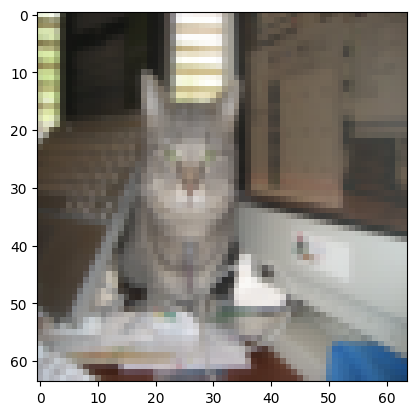

In [ ]:
# Example of a picture that was classified.
index = 7
plt.imshow(test_set_x[:,index].reshape((64, 64, 3)))
print ("y = " + str(test_set_y[0,index]) + ", it is a \"" + classes[int(d["Y_prediction_test"][0,index])].decode("utf-8") +  "\" picture.")

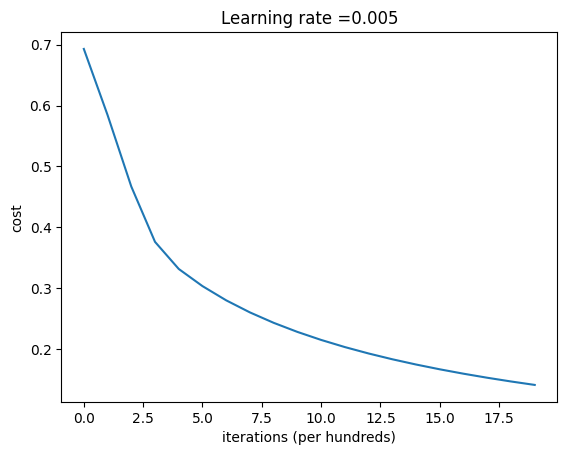

In [ ]:
# Plot learning curve (with costs)
costs = np.squeeze(d["costs"])
plt.plot(costs)
plt.ylabel("cost")
plt.xlabel("iterations (per hundreds)")
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

**Interpretation**:
The cost is decreasing. It shows that the parameters are being learned. However, you you could train the model even more on the training set. Try to increase the number of iterations in the cell above and rerun the cells. You might see that the training set accuracy goes up, but the test set accuracy goes down. This is called overfitting.

## 6 - Further analysis ##

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



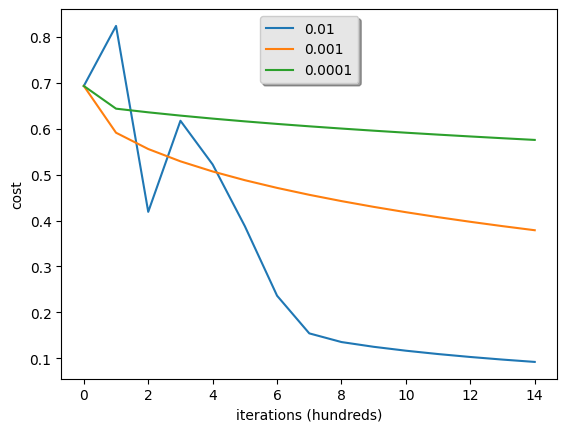

In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations=1500, learning_rate=i, print_cost=False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label=str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

**Interpretation**:
- Different learning rates give different costs and thus different predictions results.
- If the learning rate is too large (0.01), the cost may oscillate up and down. It may even diverge (though in this example, using 0.01 still eventually ends up at a good value for the cost).
- A lower cost doesn't mean a better model. You have to check if there is possibly overfitting. It happens when the training accuracy is a lot higher than the test accuracy.
- Recommendation:
    - Choose the learning rate that better minimizes the cost function.
    - If your model overfits, use other techniques to reduce overfitting.
